In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [135]:
def process_data(filename):
    df = pd.read_csv(filename).set_index('Date')
    df.index = pd.to_datetime(df.index, format = '%m/%d/%y')
    df.columns = df.columns.str.lstrip()
    df.sort_index(inplace = True)
    return df[['Close']]

In [136]:
nasdaq_df = process_data(filename = 'nasdaq.csv')
nasdaq_df = nasdaq_df[nasdaq_df.index > "2020-04-01"]

In [137]:
def make_forecast(df, target, forecast_method):
    if forecast_method == "running_average":
        # simple method: running average of past observations
        return df[target].mean()
    if forecast_method == "least_squares":
        # recursive least squares
        # note: online least squares more computationally efficient
        numerator = 0
        denominator = 0
        for k in range(1, len(df)):
            numerator += df[target].iloc[k] * df[target].iloc[k-1]
        for k in range(len(df)):
            denominator += df[target].iloc[k] ** 2
        theta_hat = numerator / denominator
        return df[target].iloc[len(df)-1] * theta_hat

In [138]:
def conformal_pid_vanilla(df, alpha, target, forecast_method):
    """
    df - dataframe
    alpha - miscoverage
    target - time series to forecast
    forecast_method - how to forecast
    """
    results, errs, scores = [], [], []
    obs_so_far = pd.DataFrame()
    n = len(df)
    # no need to make a forecast for time n+1
    for t in range(n-1):
        # new observation at time t
        new_obs = df.iloc[[t]]

        # if using online methods, we don't need to keep past observations
        obs_so_far = pd.concat([obs_so_far, new_obs])

        if t == 0:
            quantile_t = 0
            width_t = 0
            trailing10_coverage_t = 1
            trailing20_coverage_t = 1
        else:
            # score previous forecast
            score_t = abs(new_obs.values[0][0] - forecast_t)
            scores.append(score_t)
            # error if observation Xt not in the conformal prediction set (CPS)
            # in this case, the CPS is the interval: forecast_t +/- quantile_t
            err = score_t > quantile_t
            errs.append(err)
            # adaptively select the step size based on max of previous scores
            eta_t = 0.1 * np.max(scores[int(t/2):])
            # update quantile
            # if err = 1, increase quantile and grow width of CPS
            # if err = 0, decrease quantile and shrink width of CPS
            quantile_t = quantile_t + eta_t * (err - alpha)
            # widths left general in case we want to do assymetrical later on
            width_t = 2*quantile_t
            # can add user input trailing coverage later on
            trailing10_coverage_t = 1-np.mean(errs[-10:])
            trailing20_coverage_t = 1-np.mean(errs[-20:])

        # 1-step-ahead forecast using past observations
        forecast_t = make_forecast(obs_so_far,target, forecast_method)

        # add to results dataframe
        results.append({
            '1-step-ahead forecast': forecast_t,
            'lower': forecast_t - quantile_t,
            'upper': forecast_t + quantile_t,
            'width': width_t,
            'trailing10_coverage': trailing10_coverage_t,
            'trailing20_coverage': trailing20_coverage_t
        })

    # place the forecasts and CPS for time t (using times 0,...,t-1)
    # with the observation at time t in the same row
    # because no forecast made for first time
    df = df.iloc[1:].copy()
    # add new columns to df
    df = pd.concat([df,pd.DataFrame(results,index=df.index)], axis=1)

    return df

In [139]:
def conformal_pid_tangent(df, alpha, target, forecast_method):
    """
    df - dataframe
    alpha - miscoverage
    target - time series to forecast
    forecast_method - how to forecast
    """
    results, errs = [], []
    X0 = df[target].iloc[0]
    B = max(5*abs(X0),10)
    C = 6
    obs_so_far = pd.DataFrame()
    n = len(df)
    # no need to make a forecast for time n+1
    for t in range(n-1):
        # new observation at time t
        new_obs = df.iloc[[t]]

        # if using online methods, we don't need to keep past observations
        obs_so_far = pd.concat([obs_so_far, new_obs])

        if t == 0:
            quantile_t = 0
            width_t = 0
            trailing10_coverage_t = 1
            trailing20_coverage_t = 1
        else:
            # score previous forecast
            score_t = abs(new_obs.values[0][0] - forecast_t)
            # error if observation Xt not in the conformal prediction set (CPS)
            # in this case, the CPS is the interval: forecast_t +/- quantile_t
            err = score_t > quantile_t
            errs.append(err)
            errs_alpha = [error - alpha for error in errs]
            # update quantile
            quantile_t = B*np.tan((np.log(t)/((t)*C))*np.sum(errs_alpha))
            # widths left general in case we want to do assymetrical later on
            width_t = 2*quantile_t
            # can add user input trailing coverage later on
            trailing10_coverage_t = 1-np.mean(errs[-10:])
            trailing20_coverage_t = 1-np.mean(errs[-20:])

        # 1-step-ahead forecast using past observations
        forecast_t = make_forecast(obs_so_far,target, forecast_method)

        # add to results dataframe
        results.append({
            '1-step-ahead forecast': forecast_t,
            'lower': forecast_t - quantile_t,
            'upper': forecast_t + quantile_t,
            'width': width_t,
            'trailing10_coverage': trailing10_coverage_t,
            'trailing20_coverage': trailing20_coverage_t
        })

    # place the forecasts and CPS for time t (using times 0,...,t-1)
    # with the observation at time t in the same row
    # because no forecast made for first time
    df = df.iloc[1:].copy()
    # add new columns to df
    df = pd.concat([df,pd.DataFrame(results,index=df.index)], axis=1)

    return df

# Conformal Prediction: Example 0
### Vanilla quantile update and running average forecaster

In [140]:
alpha=0.05
res_ex0 = conformal_pid_vanilla(df=nasdaq_df, alpha=alpha, target='Close',
                        forecast_method='running_average')

(array([18444., 18628., 18809., 18993., 19174., 19358., 19539., 19723.]),
 [Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01')])

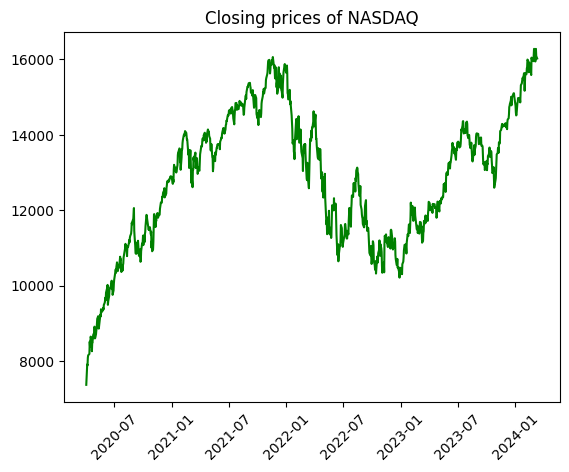

In [141]:
plt.clf()
plt.title("Closing prices of NASDAQ")
plt.plot(res_ex0.index, res_ex0['Close'], color='green')
plt.xticks(rotation=45)

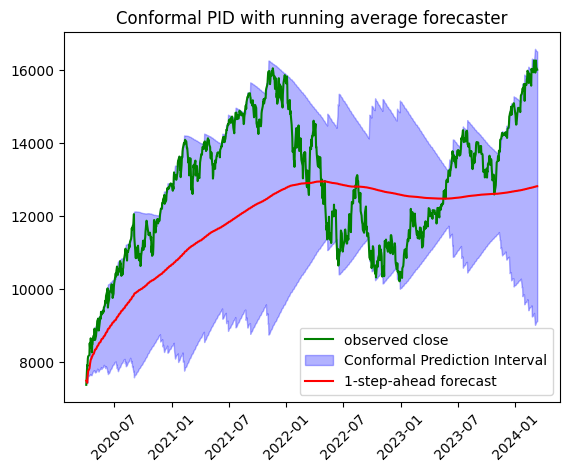

In [142]:
plt.clf()
plt.title("Conformal PID with running average forecaster")
plt.plot(res_ex0.index, res_ex0['Close'], label = "observed close",color='green')
plt.fill_between(res_ex0.index,res_ex0['lower'], res_ex0['upper'], color='blue', alpha=0.3, label='Conformal Prediction Interval')
plt.plot(res_ex0.index, res_ex0['1-step-ahead forecast'], label = "1-step-ahead forecast",color='red')
plt.xticks(rotation=45)
plt.legend()

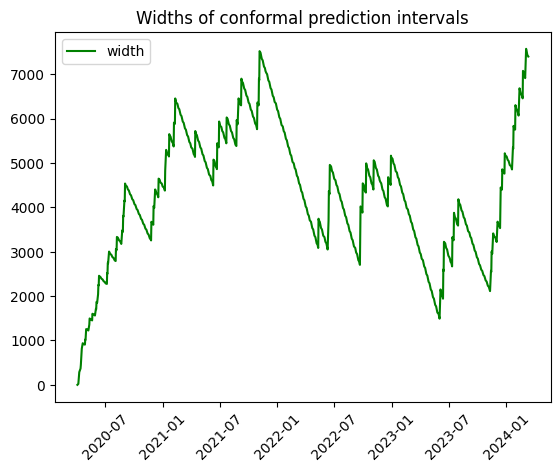

In [143]:
plt.clf()
plt.title("Widths of conformal prediction intervals")
plt.plot(res_ex0.index, res_ex0['width'], label = "width",color='green')
plt.xticks(rotation=45)
plt.legend()

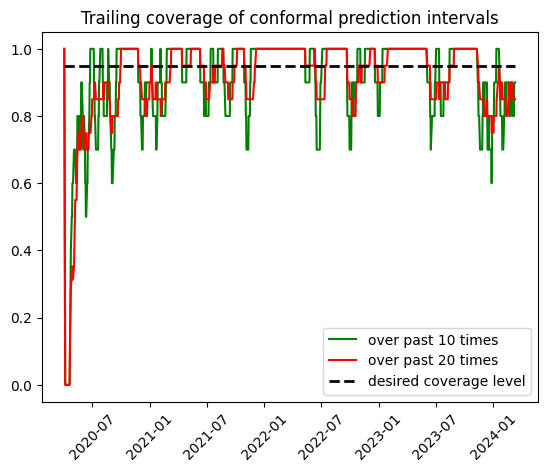

In [144]:
plt.clf()
plt.title("Trailing coverage of conformal prediction intervals")
plt.plot(res_ex0.index, res_ex0['trailing10_coverage'], label = "over past 10 times",color='green')
plt.plot(res_ex0.index, res_ex0['trailing20_coverage'], label = "over past 20 times",color='red')
plt.plot(res_ex0.index, [1-alpha]*len(res_ex0), color='black', label = "desired coverage level", linestyle='--',linewidth=2)
plt.xticks(rotation=45)
plt.legend()

# Conformal Prediction: Example 1
### Tangent integrator quantile update and running average forecaster


In [145]:
alpha=0.05
res_ex1 = conformal_pid_tangent(df=nasdaq_df, alpha=alpha,
                            target='Close',
                            forecast_method='running_average')

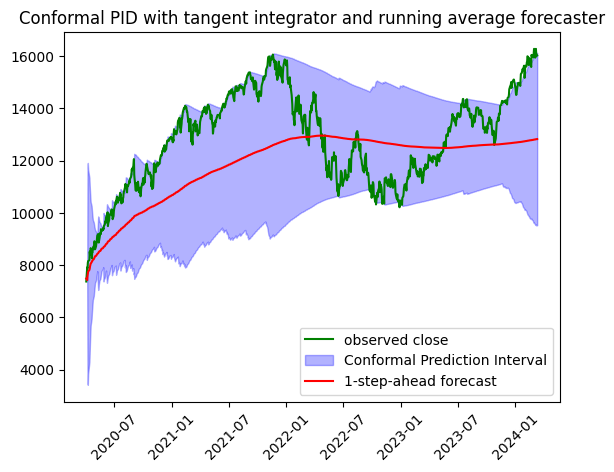

In [146]:
plt.clf()
plt.title("Conformal PID with tangent integrator and running average forecaster")
plt.plot(res_ex1.index, res_ex1['Close'], label = "observed close",color='green')
plt.fill_between(res_ex1.index,res_ex1['lower'], res_ex1['upper'], color='blue', alpha=0.3, label='Conformal Prediction Interval')
plt.plot(res_ex1.index, res_ex1['1-step-ahead forecast'], label = "1-step-ahead forecast",color='red')
plt.xticks(rotation=45)
plt.legend()

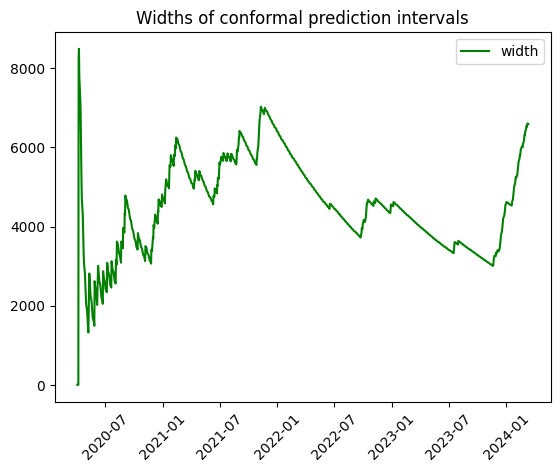

In [147]:
plt.clf()
plt.title("Widths of conformal prediction intervals")
plt.plot(res_ex1.index, res_ex1['width'], label = "width",color='green')
plt.xticks(rotation=45)
plt.legend()

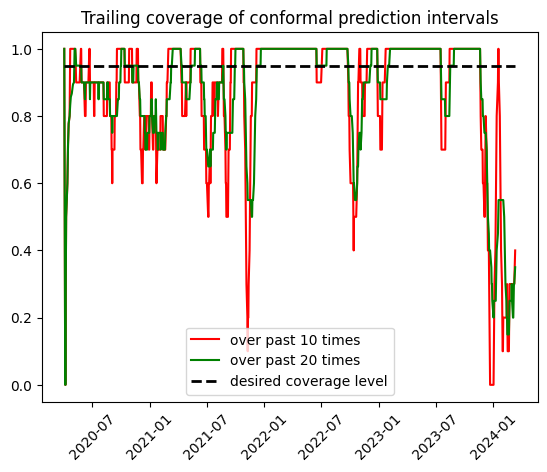

In [148]:
plt.clf()
plt.title("Trailing coverage of conformal prediction intervals")
plt.plot(res_ex1.index, res_ex1['trailing10_coverage'], label = "over past 10 times",color='red')
plt.plot(res_ex1.index, res_ex1['trailing20_coverage'], label = "over past 20 times",color='green')
plt.plot(res_ex1.index, [1-alpha]*len(res_ex1), color='black', label = "desired coverage level", linestyle='--',linewidth=2)
plt.xticks(rotation=45)
plt.legend()

# Conformal Prediction: Example 2
### Tangent integrator quantile update and least squares forecaster

In [149]:
alpha=0.05
res_ex2 = conformal_pid_tangent(df=nasdaq_df, alpha=alpha,
                            target='Close',
                            forecast_method='least_squares')

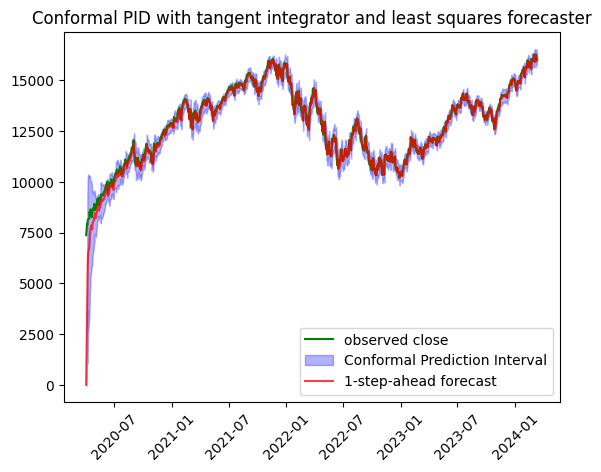

In [150]:
plt.clf()
plt.title("Conformal PID with tangent integrator and least squares forecaster")
plt.plot(res_ex2.index, res_ex2['Close'], label = "observed close",color='green')
plt.fill_between(res_ex2.index,res_ex2['lower'], res_ex2['upper'], color='blue', alpha=0.3, label='Conformal Prediction Interval')
plt.plot(res_ex2.index, res_ex2['1-step-ahead forecast'], label = "1-step-ahead forecast",color='red',alpha=0.75)
plt.xticks(rotation=45)
plt.legend()

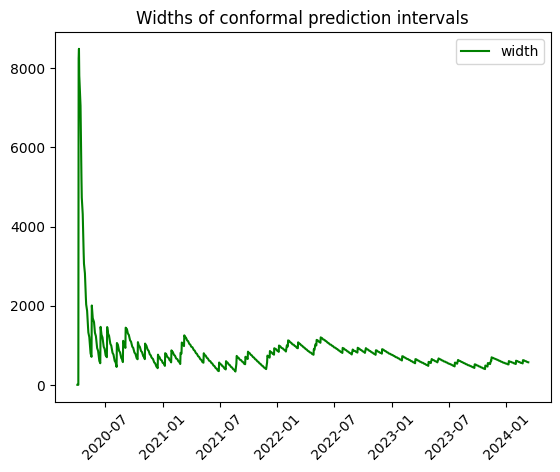

In [151]:
plt.clf()
plt.title("Widths of conformal prediction intervals")
plt.plot(res_ex2.index, res_ex2['width'], label = "width",color='green')
plt.xticks(rotation=45)
plt.legend()

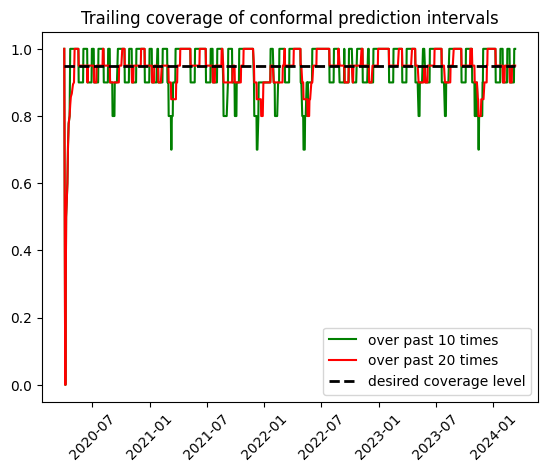

In [152]:
plt.clf()
plt.title("Trailing coverage of conformal prediction intervals")
plt.plot(res_ex2.index, res_ex2['trailing10_coverage'], label = "over past 10 times",color='green')
plt.plot(res_ex2.index, res_ex2['trailing20_coverage'], label = "over past 20 times",color='red')
plt.plot(res_ex2.index, [1-alpha]*len(res_ex2), color='black', label = "desired coverage level", linestyle='--',linewidth=2)
plt.xticks(rotation=45)
plt.legend()

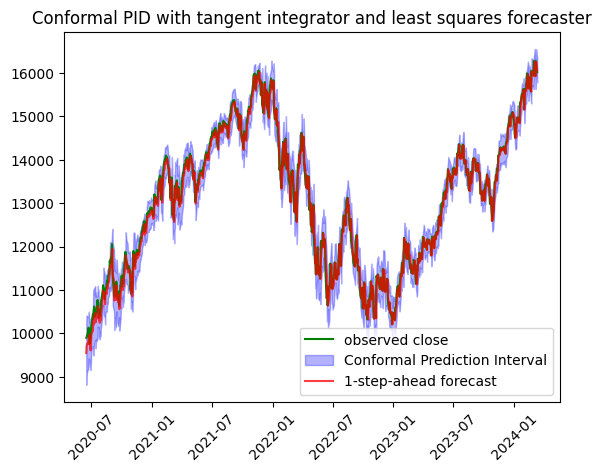

In [153]:
ts=50 # times to skip, for the sake of visualizing

# same plot just without the first few times
plt.clf()
plt.title("Conformal PID with tangent integrator and least squares forecaster")
plt.plot(res_ex2.iloc[ts:].index, res_ex2.iloc[ts:]['Close'], label = "observed close",color='green')
plt.fill_between(res_ex2.iloc[ts:].index,res_ex2.iloc[ts:]['lower'], res_ex2.iloc[ts:]['upper'], color='blue', alpha=0.3, label='Conformal Prediction Interval')
plt.plot(res_ex2.iloc[ts:].index, res_ex2.iloc[ts:]['1-step-ahead forecast'], label = "1-step-ahead forecast",color='red',alpha=0.75)
plt.xticks(rotation=45)
plt.legend()

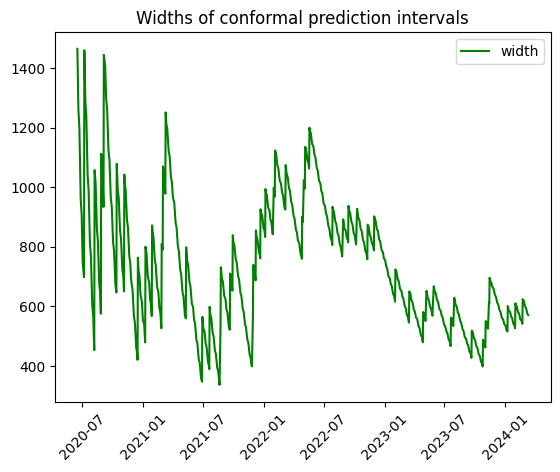

In [154]:
plt.clf()
plt.title("Widths of conformal prediction intervals")
plt.plot(res_ex2.iloc[ts:].index, res_ex2.iloc[ts:]['width'], label = "width",color='green')
plt.xticks(rotation=45)
plt.legend()

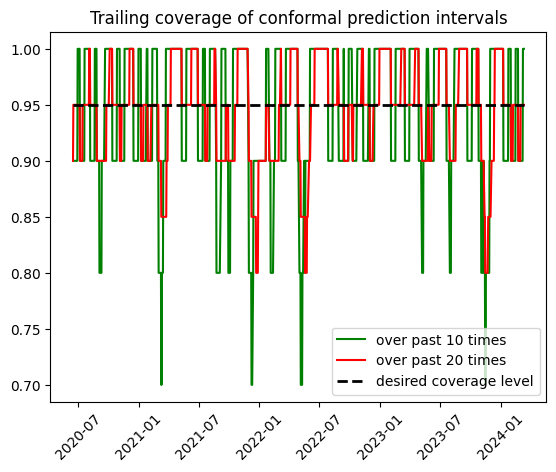

In [155]:
plt.clf()
plt.title("Trailing coverage of conformal prediction intervals")
plt.plot(res_ex2.iloc[ts:].index, res_ex2.iloc[ts:]['trailing10_coverage'], label = "over past 10 times",color='green')
plt.plot(res_ex2.iloc[ts:].index, res_ex2.iloc[ts:]['trailing20_coverage'], label = "over past 20 times",color='red')
plt.plot(res_ex2.iloc[ts:].index, [1-alpha]*len(res_ex2.iloc[ts:]), color='black', label = "desired coverage level", linestyle='--', linewidth=2)
plt.xticks(rotation=45)
plt.legend()